# Imports

In [1]:
from os import path, listdir
from copy import deepcopy
import stlearn as st
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from torch import tensor
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

%load_ext autoreload
%autoreload 2

from trainer_ae import trainer_ae
from data import get_data
from models import get_model
from tester_ae import tester_ae
from loss import *

In [2]:
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# Load Data 

In [3]:
dataset_name = 'Visium_Mouse_Olfactory_Bulb'
model_name='AE'
batch_size=128

In [4]:
dl_train, dl_valid, dl_test, df_spots_neighbors = get_data(
    model_name=model_name, 
    dataset_name=dataset_name, 
    batch_size=batch_size, 
    device=device
)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# spots: 1185 | # genes: 32285
New shape after filtering: (1185, 9528)
Log transformation step is finished in adata.X
Data shape: (11290680, 3)
Number of genes: 9528
Number of spots: 1185


<AxesSubplot:>

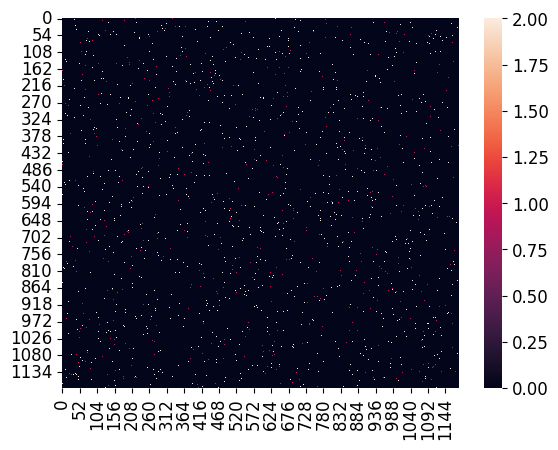

In [5]:
sns.heatmap(data=df_spots_neighbors)

# Load Model

In [7]:
params = {
    'learning_rate': 0.1,
    'optimizer': "SGD",
    'latent_dim': 40,
    'batch_size': batch_size
}

In [8]:
model = get_model(model_name=model_name, params=params, dl_train=dl_train)

# Train Model 

In [9]:
max_epochs = 300
early_stopping = 15

## Load Optimizer 

In [11]:
optimizer = getattr(optim, params['optimizer'])(model.parameters(), lr=params['learning_rate'])
criterion = NON_ZERO_RMSELoss_Spatial_AE(
    df_spots_neighbors=df_spots_neighbors,
    alpha=0.1,
    beta=0.1
)

## Train

In [12]:
model, valid_loss = trainer_ae(
    model=model, 
    optimizer=optimizer, 
    criterion=criterion,
    max_epochs=max_epochs, 
    early_stopping=early_stopping, 
    dl_train=dl_train, 
    dl_test=dl_valid, 
    device=device, 
    dataset_name=dataset_name, 
    model_name=model_name
)

2022-09-17 20:08:30.713535: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/site-packages/cv2/../../lib64:
2022-09-17 20:08:30.713583: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Training Results - Epoch[1] Avg loss: 1.29
Validation Results - Epoch[1] Avg loss: 1.29  |  Avg NonZeroRMSE: 0.90
Training Results - Epoch[2] Avg loss: 1.26
Validation Results - Epoch[2] Avg loss: 1.26  |  Avg NonZeroRMSE: 0.87
Training Results - Epoch[3] Avg loss: 1.24
Validation Results - Epoch[3] Avg loss: 1.24  |  Avg NonZeroRMSE: 0.84
Training Results - Epoch[4] Avg loss: 1.22
Validation Results - Epoch[4] Avg loss: 1.22  |  Avg NonZeroRMSE: 0.82
Training Results - Epoch[5] Avg loss: 1.21
Validation Results - Epoch[5] Avg loss: 1.21  |  Avg NonZeroRMSE: 0.81
Training Results - Epoch[6] Avg loss: 1.19
Validation Results - Epoch[6] Avg loss: 1.20  |  Avg NonZeroRMSE: 0.79
Training Results - Epoch[7] Avg loss: 1.19
Validation Results - Epoch[7] Avg loss: 1.19  |  Avg NonZeroRMSE: 0.78
Training Results - Epoch[8] Avg loss: 1.18
Validation Results - Epoch[8] Avg loss: 1.18  |  Avg NonZeroRMSE: 0.77
Training Results - Epoch[9] Avg loss: 1.17
Validation Results - Epoch[9] Avg loss: 1.18 

2022-09-17 20:23:40,291 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Results - Epoch[51] Avg loss: 1.14  |  Avg NonZeroRMSE: 0.70


In [13]:
train_res = 0.70
valid_res = 0.70
print(f'Train final results (after log transform) = {train_res}')
print(f'Train final results = {np.exp(train_res)}')
print(f'Valid final results (after log transform) = {valid_res}')
print(f'Valid final results = {np.exp(valid_res)}')

Train final results (after log transform) = 0.7
Train final results = 2.0137527074704766
Valid final results (after log transform) = 0.7
Valid final results = 2.0137527074704766


## Test 

In [14]:
loss_fn = RMSELoss()

test_loss, _ = tester_ae(
    model=model,
    dl_test=dl_test,
    device=device,
    loss_fn=loss_fn
)
print(f'Test loss (after log transform) = {test_loss}')
print(f'Test loss = {torch.exp(test_loss)}')

Test loss (after log transform) = 0.7338624596595764
Test loss = 2.083111047744751
